In [1]:
suppressMessages(library("limma"))
suppressMessages(library("ggplot2"))
suppressMessages(library("WGCNA"))
options(stringsAsFactors = FALSE)

*
*  Package WGCNA 1.64.1 loaded.
*
*    Important note: It appears that your system supports multi-threading,
*    but it is not enabled within WGCNA in R. 
*    To allow multi-threading within WGCNA with all available cores, use 
*
*          allowWGCNAThreads()
*
*    within R. Use disableWGCNAThreads() to disable threading if necessary.
*    Alternatively, set the following environment variable on your system:
*
*          ALLOW_WGCNA_THREADS=<number_of_processors>
*
*    for example 
*
*          ALLOW_WGCNA_THREADS=8
*
*    To set the environment variable in linux bash shell, type 
*
*           export ALLOW_WGCNA_THREADS=8
*
*     before running R. Other operating systems or shells will
*     have a similar command to achieve the same aim.
*




In [2]:
load("../data/filtered_TMT_Summary_Data_FC.RData")
load("../data/Quantile_TMT_Summary_Data_FC.RData")

In [3]:
nCols <- ncol(Quantile_TMT_Summary_Data)
nGenes <- nrow(Quantile_TMT_Summary_Data)

# additive linear model
addBatchFactor <- c(2,2,1,1,3,3,4,4)
addDiseaseGroup <- factor(rep(addBatchFactor,5))
addDesign <- model.matrix(~addDiseaseGroup + 0)
colnames(addDesign) <- c("Ctl", "AD", "PD","ADPD")

addFit <- lmFit(Quantile_TMT_Summary_Data, addDesign)

contrast.matrix <- makeContrasts(AD-Ctl, PD-Ctl, ADPD-Ctl, levels=addDesign)
addFit2 <- contrasts.fit(addFit, contrast.matrix)
addFit2 <- eBayes(addFit2)
topGenesAdd <- topTable(addFit2, coef=1, adjust="BH")

# interaction linear model
Ctl <-factor(rep(c(0,0,1,1,0,0,0,0),5))
AD <- factor(rep(c(1,1,0,0,0,0,1,1),5))
PD <- factor(rep(c(0,0,0,0,1,1,1,1),5))
intDesign <- model.matrix(~Ctl + AD + PD + AD:PD + 0)
intDesign <- intDesign[,2:5]
colnames(intDesign) <- c("Ctl", "AD", "PD","ADPD")

intFit <- lmFit(Quantile_TMT_Summary_Data, intDesign)

contrast.matrix <- makeContrasts(AD-Ctl, PD-Ctl, ADPD-Ctl, levels=intDesign)
intFit2 <- contrasts.fit(intFit, contrast.matrix)
intFit2 <- eBayes(intFit2)
topGenesInt <- topTable(intFit2, coef=1, adjust="BH")

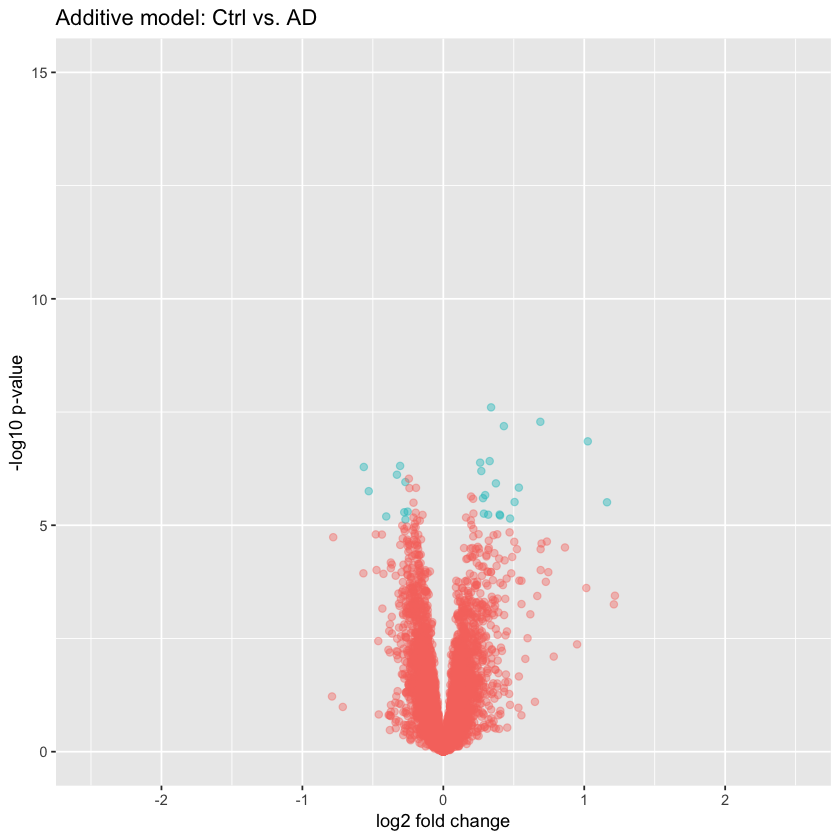

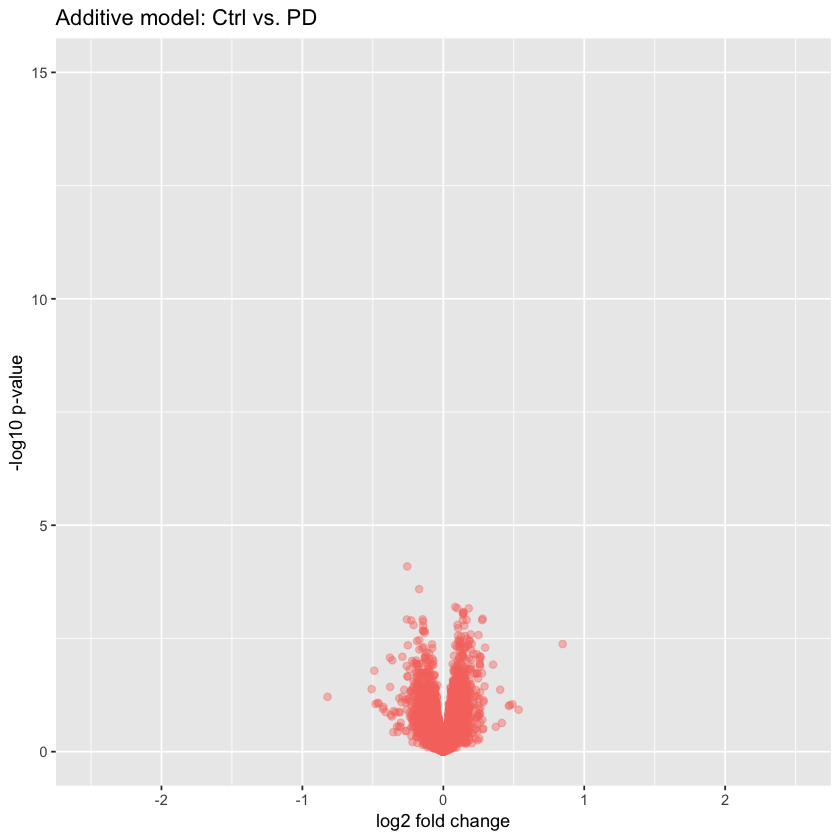

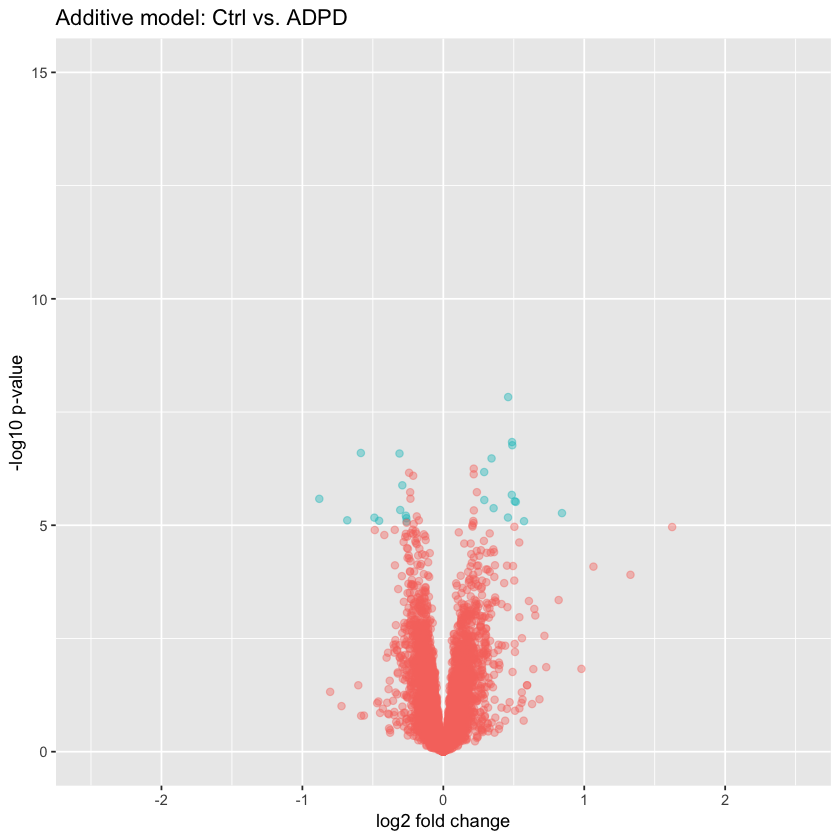

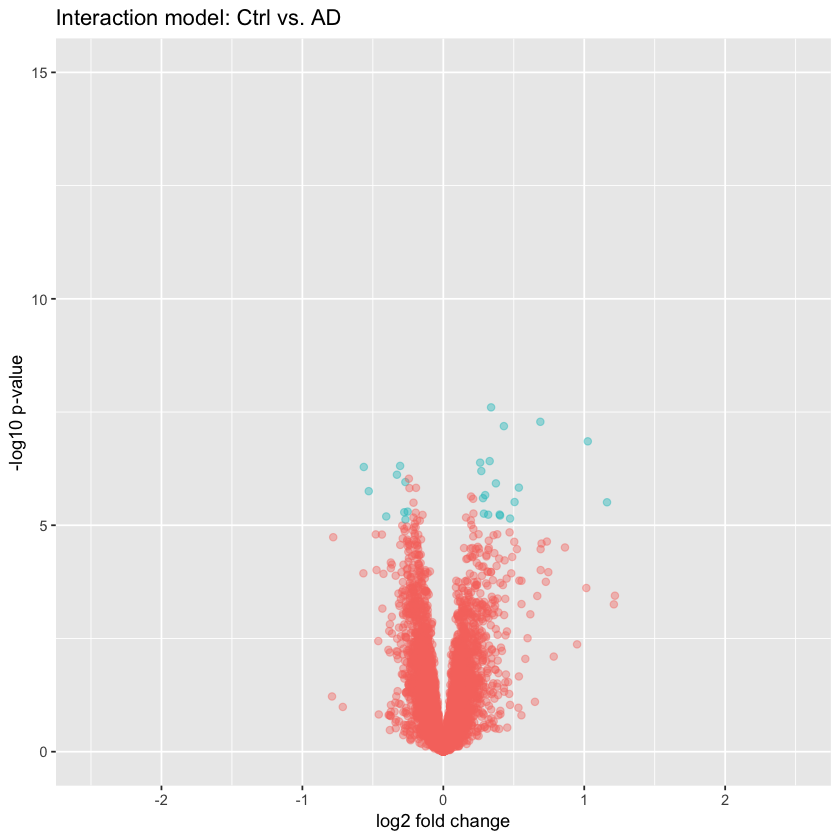

Warning message:
“Removed 5318 rows containing missing values (geom_point).”

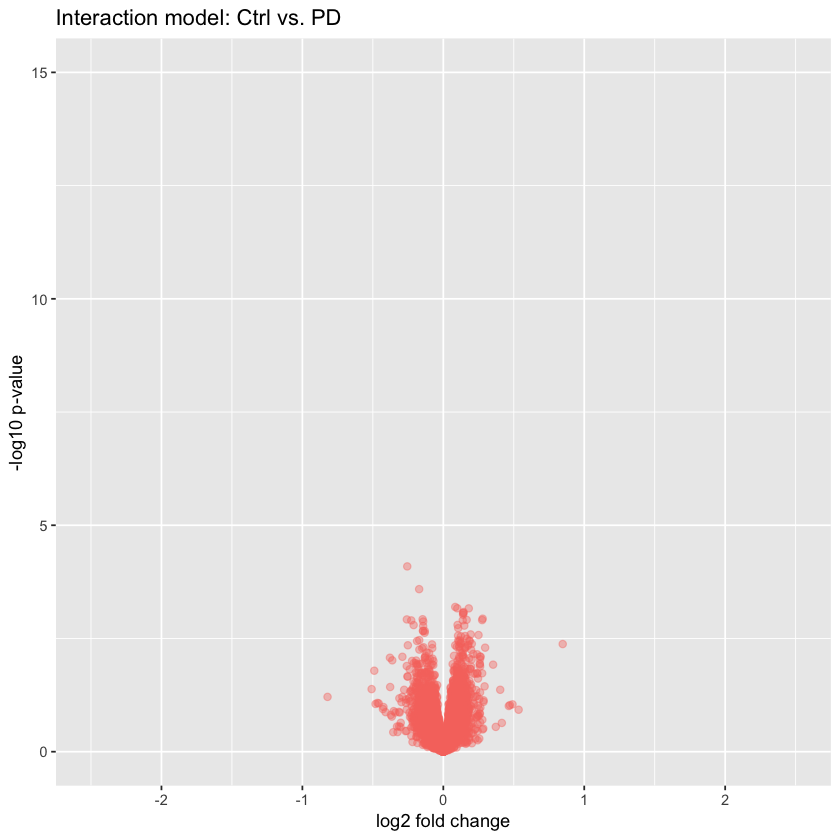

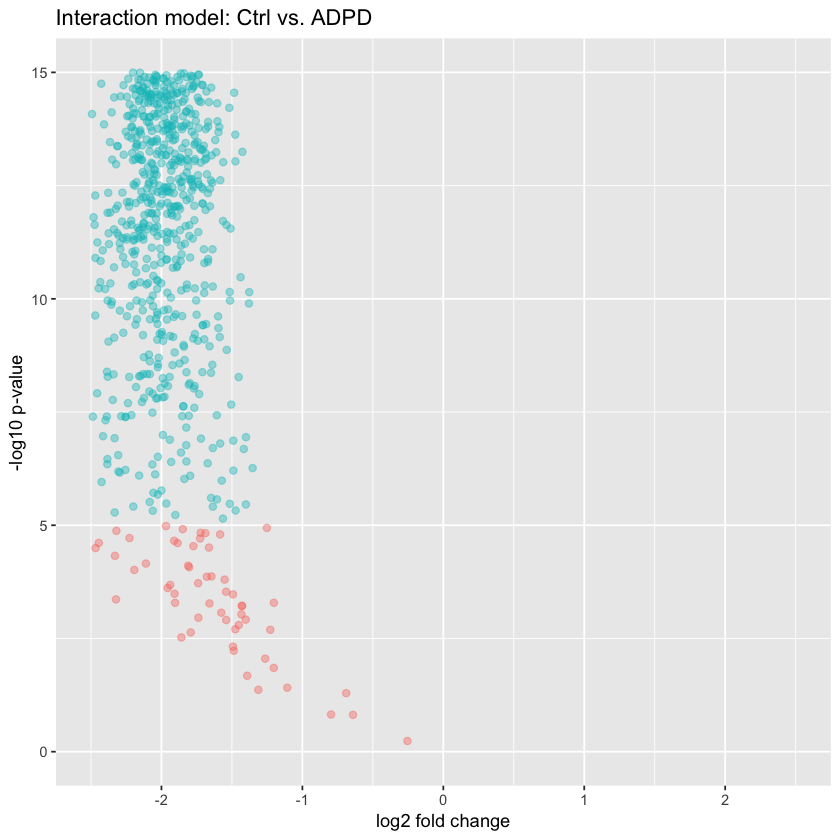

In [4]:
# Generate Log-fold changes
adAddGenes <- topTable(addFit2, coef=1, number=1000000, sort.by="logFC")
pdAddGenes <- topTable(addFit2, coef=2, number=1000000, sort.by="logFC")
adpdAddGenes <- topTable(addFit2, coef=3, number=1000000, sort.by="logFC")

adIntGenes <- topTable(intFit2, coef=1, number=1000000, sort.by="logFC")
pdIntGenes <- topTable(intFit2, coef=2, number=1000000, sort.by="logFC")
adpdIntGenes <- topTable(intFit2, coef=3, number=1000000, sort.by="logFC")

# Add compute expressed genes threshold (TRUE is differentially expressed)
adAddGenes$threshold = as.factor(abs(adAddGenes$logFC) > 0.25 & adAddGenes$P.Value < 0.05/nGenes)
pdAddGenes$threshold = as.factor(abs(pdAddGenes$logFC) > 0.25 & pdAddGenes$P.Value < 0.05/nGenes)
adpdAddGenes$threshold = as.factor(abs(adpdAddGenes$logFC) > 0.25 & adpdAddGenes$P.Value < 0.05/nGenes)

adIntGenes$threshold = as.factor(abs(adIntGenes$logFC) > 0.25 & adIntGenes$P.Value < 0.05/nGenes)
pdIntGenes$threshold = as.factor(abs(pdIntGenes$logFC) > 0.25 & pdIntGenes$P.Value < 0.05/nGenes)
adpdIntGenes$threshold = as.factor(abs(adpdIntGenes$logFC) > 0.25 & adpdIntGenes$P.Value < 0.05/nGenes)

# Generate volcano plots using the additive model.
g1 = ggplot(data=adAddGenes, aes(x=logFC, y=-log10(P.Value), colour=threshold)) +
  geom_point(alpha=0.4, size=1.75) +
  theme(legend.position = "none") +
  xlim(c(-2.5, 2.5)) + ylim(c(0, 15)) +
  xlab("log2 fold change") + ylab("-log10 p-value") + ggtitle('Additive model: Ctrl vs. AD')
g1

g2 = ggplot(data=pdAddGenes, aes(x=logFC, y=-log10(P.Value), colour=threshold)) +
  geom_point(alpha=0.4, size=1.75) +
  theme(legend.position = "none") +
  xlim(c(-2.5, 2.5)) + ylim(c(0, 15)) +
  xlab("log2 fold change") + ylab("-log10 p-value") + ggtitle('Additive model: Ctrl vs. PD')
g2

g3 = ggplot(data=adpdAddGenes, aes(x=logFC, y=-log10(P.Value), colour=threshold)) +
  geom_point(alpha=0.4, size=1.75) +
  theme(legend.position = "none") +
  xlim(c(-2.5, 2.5)) + ylim(c(0, 15)) +
  xlab("log2 fold change") + ylab("-log10 p-value") + ggtitle('Additive model: Ctrl vs. ADPD')
g3

# Generate volcano plots using the interaction model.
g4 = ggplot(data=adIntGenes, aes(x=logFC, y=-log10(P.Value), colour=threshold)) +
  geom_point(alpha=0.4, size=1.75) +
  theme(legend.position = "none") +
  xlim(c(-2.5, 2.5)) + ylim(c(0, 15)) +
  xlab("log2 fold change") + ylab("-log10 p-value") + ggtitle('Interaction model: Ctrl vs. AD')
g4

g5 = ggplot(data=pdIntGenes, aes(x=logFC, y=-log10(P.Value), colour=threshold)) +
  geom_point(alpha=0.4, size=1.75) +
  theme(legend.position = "none") +
  xlim(c(-2.5, 2.5)) + ylim(c(0, 15)) +
  xlab("log2 fold change") + ylab("-log10 p-value") + ggtitle('Interaction model: Ctrl vs. PD')
g5

g6 = ggplot(data=adpdIntGenes, aes(x=logFC, y=-log10(P.Value), colour=threshold)) +
  geom_point(alpha=0.4, size=1.75) +
  theme(legend.position = "none") +
  xlim(c(-2.5, 2.5)) + ylim(c(0, 15)) +
  xlab("log2 fold change") + ylab("-log10 p-value") + ggtitle('Interaction model: Ctrl vs. ADPD')
g6

In [5]:
# Might have to do manual construction of blocks to get the maximally connected genes

get_max_conn_genes <- function(data, data_mat, ad_ctl_len, pd_ctl_len, adpd_ctl_len, softPower, min_mod_size){
  softPower = softPower;
  adjacency = adjacency(data, power = softPower);
  
  # Turn adjacency into topological overlap
  TOM = TOMsimilarity(adjacency);
  dissTOM = 1-TOM
  
  # Call the hierarchical clustering function
  geneTree = hclust(as.dist(dissTOM), method = "average");
  # Plot the resulting clustering tree (dendrogram)
  sizeGrWindow(12,9)
  plot(geneTree, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",
  labels = FALSE, hang = 0.04);
  
  minModuleSize = 1;
  # Module identification using dynamic tree cut:
  dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM,
  deepSplit = 2, pamRespectsDendro = FALSE,
  minClusterSize = min_mod_size);
  table(dynamicMods)
  
  # Convert numeric lables into colors
  dynamicColors = labels2colors(dynamicMods)
  table(dynamicColors)
  # Plot the dendrogram and colors underneath
  sizeGrWindow(8,6)
  plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut",
  dendroLabels = FALSE, hang = 0.03,
  addGuide = TRUE, guideHang = 0.05,
  main = "Gene dendrogram and module colors")
  
  "
  # Maximally connected gene, let's call it mc_gene
  # For each cluster, find elements in that cluster, sum up the corresponding row from the     adjacency matrix.
  mc_genes = list()
  for(i in c(1:max(dynamicMods))){
    all_row_indices = which(dynamicMods == i)
    max_val = -1
    max_idx = -1
    for(id in all_row_indices){
      curr_sum = sum(adjacency[id,all_row_indices])
      if(curr_sum>max_val){
        max_val = curr_sum
        max_idx = id
      }
    }
    mc_genes[[i]] <- rownames(data_mat[max_idx,])
  }
  "
  
  # Calculate eigengenes
  MEList = moduleEigengenes(data, colors = dynamicColors)
  MEs = MEList$eigengenes
  # Calculate dissimilarity of module eigengenes
  MEDiss = 1-cor(MEs);
  # Cluster module eigengenes
  METree = hclust(as.dist(MEDiss), method = "average");
  # Plot the result
  sizeGrWindow(7, 6)
  plot(METree, main = "Clustering of module eigengenes",
  xlab = "", sub = "")
  
  MEDissThres = 0.2
  # Plot the cut line into the dendrogram
  abline(h=MEDissThres, col = "red")
  # Call an automatic merging function
  merge = mergeCloseModules(data, dynamicColors, cutHeight = MEDissThres, verbose = 3)
  # The merged module colors
  mergedColors = merge$colors;
  # Eigengenes of the new merged modules:
  mergedMEs = merge$newMEs;
  
  sizeGrWindow(12, 9)
  #pdf(file = "Plots/geneDendro-3.pdf", wi = 9, he = 6)
  adpd_colors = c(rep("blue",ad_ctl_len), rep("green", pd_ctl_length), rep("red",adpd_ctl_length))
  plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors, adpd_colors),
  c("Dynamic Tree Cut", "Merged dynamic", "R:AD, B:ADPD, G:PD"),
  dendroLabels = FALSE, hang = 0.03,
  addGuide = TRUE, guideHang = 0.05)
  
  # Rename to moduleColors
  moduleColors = mergedColors
  # Construct numerical labels corresponding to the colors
  colorOrder = c("grey", standardColors(50));
  moduleLabels = match(moduleColors, colorOrder)-1;
  MEs = mergedMEs;
  return(moduleLabels)
}

In [6]:
# Get all differentially expressed genes into a dataframe


ad_ctl <-  as.data.frame((Quantile_TMT_Summary_Data[as.integer(rownames(adAddGenes[which(adAddGenes$threshold == TRUE),])), c(1,2,7:nCols)]))
rownames(ad_ctl) <- ad_ctl[,1]
ad_ctl_length = length(rownames(ad_ctl))
ad_ctl[,1] <- NULL

pd_ctl <-  as.data.frame((Quantile_TMT_Summary_Data[as.integer(rownames(pdAddGenes[which(pdAddGenes$threshold == TRUE),])), c(1,2,7:nCols)]))
rownames(pd_ctl) <- pd_ctl[,1]
pd_ctl_length = length(rownames(pd_ctl))
pd_ctl[,1] <- NULL

adpd_ctl <-  as.data.frame((Quantile_TMT_Summary_Data[as.integer(rownames(adpdAddGenes[which(adpdAddGenes$threshold == TRUE),])), c(1,2,7:nCols)]))
rownames(adpd_ctl) <- adpd_ctl[,1]
adpd_ctl_length = length(rownames(adpd_ctl))
adpd_ctl[,1] <- NULL

all_diff <- rbind(ad_ctl,pd_ctl,adpd_ctl)

In [7]:
all_diff_data <- all_diff[,-1]
all_diff_data <- t(all_diff_data)

gsg = goodSamplesGenes(all_diff_data, verbose = 3);
gsg$allOK


# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to=20, by=2))
# Call the network topology analysis function
sft = pickSoftThreshold(all_diff_data, powerVector = powers, verbose = 5)
# Plot the results:
sizeGrWindow(9, 5)
par(mfrow = c(1,2));
cex1 = 0.9;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.70,col="red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

pickSoftThreshold: will use block size 51.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 51 of 51


Warning message:
“executing %dopar% sequentially: no parallel backend registered”

   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.2430 17.4000        0.02750  32.100    33.500  35.90
2      2   0.3610  2.1900        0.44700  21.500    22.900  26.40
3      3   0.6040  1.3900        0.66200  14.800    16.100  19.80
4      4   0.5360  0.8110        0.49700  10.600    11.500  15.20
5      5   0.3700  0.5220        0.20900   7.700     8.380  12.00
6      6   0.2900  0.3620        0.08940   5.740     6.210   9.61
7      7   0.0730  0.1780       -0.19200   4.380     4.720   7.85
8      8   0.0020  0.0204       -0.28300   3.410     3.560   6.51
9      9   0.0191 -0.0559       -0.26100   2.720     2.720   5.47
10    10   0.0933 -1.9300       -0.04500   2.210     2.230   4.65
11    12   0.0901 -1.8700       -0.15000   1.550     1.410   3.66
12    14   0.1000 -1.7300       -0.12700   1.170     0.886   3.35
13    16   0.1850 -3.4300        0.00197   0.948     0.601   3.19
14    18   0.2470 -4.2900        0.05970   0.812     0.429   3.10
15    20  

In [8]:
all_diff

,AD2,ADPD1,ADPD2,AD3,AD4,CTL3,CTL4,PD3,PD4,ADPD3,⋯,ADPD7,ADPD8,AD9,AD10,CTL9,CTL10,PD9,PD10,ADPD9,ADPD10
2.10144304799588,2.2899974,2.2005063,1.8392837,1.0870680,1.4757825,0.2586172,0.7146858,0.6552151,0.4213039,1.2736774,⋯,1.4583357,0.7110044,1.0384591,2.8388056,0.6162666,1.1343742,0.6280127,0.6866762,0.5764706,1.5061252
2.67118447236489,2.8388056,1.6624302,1.5733165,1.2016848,1.1490647,0.6562342,0.5693575,0.5053923,0.5350142,1.1744819,⋯,1.9670068,0.9614315,1.3754851,1.5774708,0.3974508,0.7237548,0.4853309,0.6253682,1.3677501,1.3253818
1.68118624388749,1.7877402,1.4864183,1.5191045,1.1454512,1.3120564,0.6345204,0.6953016,0.7749397,0.6964220,1.0163611,⋯,1.3784144,0.8308245,1.1336965,1.9872470,0.8272864,0.9340583,0.7365587,0.7656948,0.6742911,1.5038991
0.5837446331982,0.6785547,0.5764706,0.7134058,0.9905124,1.1794291,1.2156000,1.4443711,1.3677501,0.8441635,0.6578304,⋯,0.6861248,1.1266694,0.9832167,1.2871868,1.4685606,1.4704953,1.2283818,1.1415717,1.1427850,1.0301203
1.73536146911046,1.3081004,1.3742623,1.0392580,1.2176132,0.7859416,0.6772237,0.8328595,0.7958923,0.9760282,1.6024705,⋯,1.1991489,0.8687617,1.1893745,1.5575373,0.7494193,0.8225982,0.9420592,0.6481016,0.8547568,1.5091793
0.510650219623547,0.7048103,0.7011102,0.8713310,0.9404538,1.3570411,1.3128591,1.4981752,1.4666308,0.9928953,0.5525270,⋯,0.6608807,1.1838310,0.6608807,0.9241825,1.1085621,1.0241698,1.0838645,1.3440402,1.0397327,0.6313759
1.47428751066812,1.4246655,1.6099734,1.5061252,0.9807405,0.9316554,0.6981821,0.6438140,0.6866762,0.6507879,1.1338195,⋯,1.2611767,0.8361171,1.2650612,1.4271235,0.7879567,0.7255882,0.5053923,0.6578304,0.8009571,1.6580330
1.71504088813658,1.6099734,1.1042113,1.2936323,0.9926923,0.8564777,0.7758755,0.8508117,0.9267273,0.9597142,1.4356389,⋯,1.2778645,0.8364170,1.1636077,1.4427334,0.5491192,1.1037227,0.9734923,0.8277540,1.0062961,1.1101734
1.46856061614266,1.2987245,1.4398372,1.2964347,1.0665308,0.9349921,0.7435910,0.6371192,0.8052775,0.8440260,1.1712704,⋯,1.3498077,0.8823229,1.0163611,0.8672924,0.7473055,0.7467719,0.6718971,0.8185346,1.1000401,1.0937472
0.578003925886905,0.7770071,0.7271224,0.9636779,0.9798476,1.3202217,1.1767323,1.4547043,0.9866159,1.0290693,0.8798617,⋯,1.1058503,0.7130142,0.7220216,0.6376111,1.2345818,0.9959051,1.0919558,1.1800516,0.9717108,0.8230266


In [9]:
module_labels = get_max_conn_genes(all_diff_data, all_diff, ad_ctl_length, pd_ctl_length, adpd_ctl_length, 18, 2)
# For each cluster
for(i in unique(module_labels)){
  if(i!=0){
    all_row_indices = which(colors_merge == i)
    
    from_ad = sum(all_row_indices<=27)
    from_adpd = length(all_row_indices) - from_ad
    print(c(from_ad, from_adpd))
} 
}

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..cutHeight not given, setting it to 0.99  ===>  99% of the (truncated) height range in dendro.
 ..done.
 mergeCloseModules: Merging modules whose distance is less than 0.2
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 11 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 7 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 6 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 4 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 4 module eigengenes in given set.


ERROR: Error in which(colors_merge == i): object 'colors_merge' not found
